This is Part 4 of the DSO 429 Machine Learning Assignment.

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


Supress Warnings

In [ ]:
# Suppress common warnings during grid search on small datasets
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

--- 1. Data Loading and Cleaning ---
Initial Dataset Shape: (920, 13)

Engineered features being handled by FeatureEngineerTransformer.

--- 6. Model Training and Evaluation (AUC Score) ---

Tuning and evaluating: Logistic Regression...
  Best Cross-Validation AUC: 0.8880
  Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'preprocessor__num__imputer__strategy': 'mean'}
  Final Test AUC: 0.8833

Tuning and evaluating: Decision Tree...
  Best Cross-Validation AUC: 0.8235
  Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5}
  Final Test AUC: 0.8413

Tuning and evaluating: Support Vector Machine (SVC)...
  Best Cross-Validation AUC: 0.8925
  Best Parameters: {'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
  Final Test AUC: 0.8994

--- 7. Final Model Performance Report ---
Model: Logistic Regression - Test AUC: 0.8833
Model: Decision Tree - Test AUC: 0.8413
Model: Support Vector Machine (SVC) - Test AUC: 0.8994



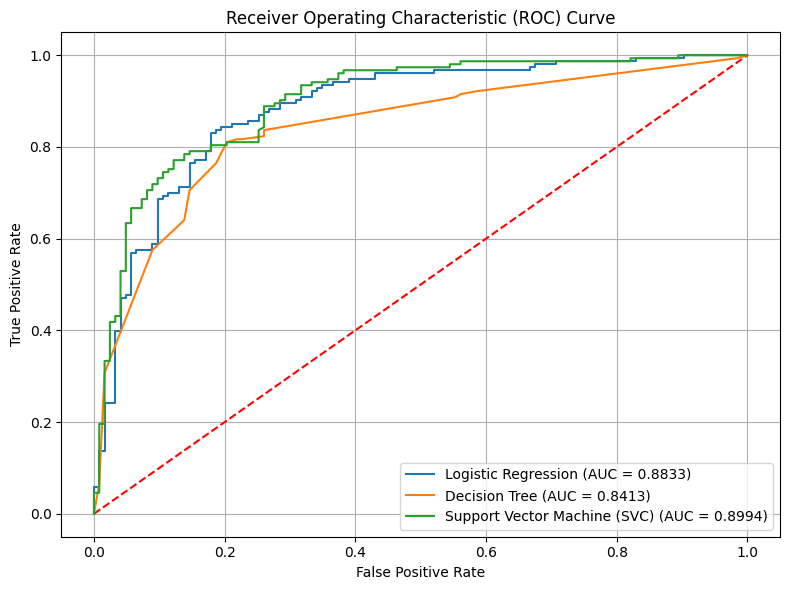

In [ ]:
# Loading the data

# --- 1. DATA LOADING AND INITIAL CLEANING ---

print("--- 1. Data Loading and Cleaning ---")
# Convert '?' to NaN on load
df = pd.read_csv('heart_disease_uci.csv', na_values='?')

# Normalize common header typo(s)
df.rename(columns={'thalch': 'thalach'}, inplace=True)

# Target: num > 0 => 1 (disease), num == 0 => 0 (no disease)
df['num_binary'] = (df['num'] > 0).astype(int)
y = df['num_binary']

# Drop columns that shouldn't be features if present
drop_cols = [c for c in ['num', 'num_binary', 'id', 'dataset'] if c in df.columns]
X = df.drop(columns=drop_cols)
print(f"Initial Dataset Shape: {X.shape}")










In [ ]:
# --- 2. FEATURE ENGINEERING (CUSTOM TRANSFORMER) ---

class FeatureEngineerTransformer(BaseEstimator, TransformerMixin):
    """
    Robust FE:
      - Cast key columns to numeric (coerce)
      - Support common column aliases (includes 'thalch' for safety)
      - Fail fast with a clear message if required base columns are missing
    """
    def __init__(self, col_aliases=None):
        self.col_aliases = col_aliases or {
            'chol':      ['cholesterol'],
            'trestbps':  ['restbps', 'resting_blood_pressure'],
            'fbs':       ['fasting_blood_sugar'],
            'thalach':   ['thalch', 'thalach_max', 'max_hr', 'max_heart_rate', 'thalachh'],
            'exang':     ['exercise_induced_angina', 'ex_induced_angina']
        }
        self.required_base = ['chol', 'trestbps', 'fbs', 'thalach', 'exang']

    def _get_series(self, X, name):
        candidates = [name] + self.col_aliases.get(name, [])
        for c in candidates:
            if c in X.columns:
                return pd.to_numeric(X[c], errors='coerce')
        raise KeyError(
            f"Expected column '{name}' not found. "
            f"Tried aliases {candidates}. Available: {list(X.columns)}"
        )

    def fit(self, X, y=None):
        # Validate presence of required columns (or their aliases)
        _ = [self._get_series(X, nm) for nm in self.required_base]
        return self

    def transform(self, X):
        X_out = X.copy()

        # Pull numeric versions safely
        chol     = self._get_series(X_out, 'chol')
        trestbps = self._get_series(X_out, 'trestbps')
        fbs      = self._get_series(X_out, 'fbs')
        thalach  = self._get_series(X_out, 'thalach')
        exang    = self._get_series(X_out, 'exang').fillna(0)  # treat NA as no angina

        # --- Feature 1: High-Risk Factor Count ---
        X_out['high_chol']  = (chol > 200).astype(int).fillna(0)
        X_out['high_bp']    = (trestbps > 140).astype(int).fillna(0)
        X_out['high_sugar'] = (fbs == 1).astype(int).fillna(0)
        X_out['high_risk_factor_count'] = (
            X_out['high_chol'] + X_out['high_bp'] + X_out['high_sugar']
        )
        X_out = X_out.drop(columns=['high_chol', 'high_bp', 'high_sugar'])

        # --- Feature 2: Exercise Inadequacy Index ---
        # (max heart rate) * (1 - exang)
        X_out['exercise_inadequacy_index'] = thalach * (1 - exang)

        return X_out

print("\nEngineered features being handled by FeatureEngineerTransformer.")


Engineered features being handled by FeatureEngineerTransformer.


In [ ]:
# --- 3. DATA SPLIT AND DEFINING COLUMNS ---

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Define column names based on the *raw* data, knowing FE adds two new numerical ones.
original_numerical_features = X.select_dtypes(include=np.number).columns.tolist()
original_categorical_features = X.select_dtypes(include='object').columns.tolist()

# Ensure 'thal' is treated as categorical even if it is int-coded
categorical_cols_to_process = sorted(set(original_categorical_features + ['thal']))

# Columns that the preprocessor will receive *after* FE:
numerical_cols_to_process = original_numerical_features + [
    'high_risk_factor_count',
    'exercise_inadequacy_index'
]


In [ ]:
# --- 4. PIPELINE SETUP (Preprocessor) ---

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols_to_process),
        ('cat', categorical_pipeline, categorical_cols_to_process)
    ],
    remainder='drop'
)

In [ ]:
# --- 5. MODEL PIPELINE AND HYPERPARAMETER TUNING ---

models_and_params = {
    'Logistic Regression': (
        LogisticRegression(max_iter=5000, random_state=42),
        {
            'preprocessor__num__imputer__strategy': ['mean', 'median'],
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__penalty': ['l2']
        }
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42),
        {
            'classifier__max_depth': [3, 5, 7, 9],
            'classifier__min_samples_leaf': [5, 10, 20]
        }
    ),
    'Support Vector Machine (SVC)': (
        SVC(probability=True, random_state=42),
        {
            'classifier__C': [0.1, 1, 10, 100],
            'classifier__gamma': ['scale', 'auto'],
            'classifier__kernel': ['rbf']
        }
    )
}

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\n--- 6. Model Training and Evaluation (AUC Score) ---")

for name, (model, params) in models_and_params.items():
    print(f"\nTuning and evaluating: {name}...")

    # Full pipeline: Feature Engineering -> Preprocessor -> Classifier
    full_pipeline = Pipeline(steps=[
        ('fe', FeatureEngineerTransformer()),  # 1. Feature Engineering
        ('preprocessor', preprocessor),        # 2. Impute, Scale, OHE
        ('classifier', model)                  # 3. Model
    ])

    grid_search = GridSearchCV(
        full_pipeline,
        params,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
        # , error_score='raise'  # uncomment to surface failures immediately
    )

    grid_search.fit(X_train_raw, y_train)
    best_model = grid_search.best_estimator_

    # Prediction on held-out test set
    y_test_proba = best_model.predict_proba(X_test_raw)[:, 1]

    # Final AUC
    test_auc = roc_auc_score(y_test, y_test_proba)

    results[name] = {
        'best_params': grid_search.best_params_,
        'test_auc': test_auc,
        'best_estimator': best_model
    }

    print(f"  Best Cross-Validation AUC: {grid_search.best_score_:.4f}")
    print(f"  Best Parameters: {dict(grid_search.best_params_)}")
    print(f"  Final Test AUC: {test_auc:.4f}")


--- 6. Model Training and Evaluation (AUC Score) ---

Tuning and evaluating: Logistic Regression...
  Best Cross-Validation AUC: 0.8880
  Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'preprocessor__num__imputer__strategy': 'mean'}
  Final Test AUC: 0.8833

Tuning and evaluating: Decision Tree...
  Best Cross-Validation AUC: 0.8235
  Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5}
  Final Test AUC: 0.8413

Tuning and evaluating: Support Vector Machine (SVC)...
  Best Cross-Validation AUC: 0.8925
  Best Parameters: {'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
  Final Test AUC: 0.8994



--- 7. Final Model Performance Report ---
Model: Logistic Regression - Test AUC: 0.8833
Model: Decision Tree - Test AUC: 0.8413
Model: Support Vector Machine (SVC) - Test AUC: 0.8994

Conclusion: The best performing model is the Support Vector Machine (SVC) with an AUC of 0.8994.


Reason for superior performance:
The SVC with an RBF kernel performed best, indicating non-linear structure in the transformed feature space; maximizing the margin in a higher-dimensional map generalized well.


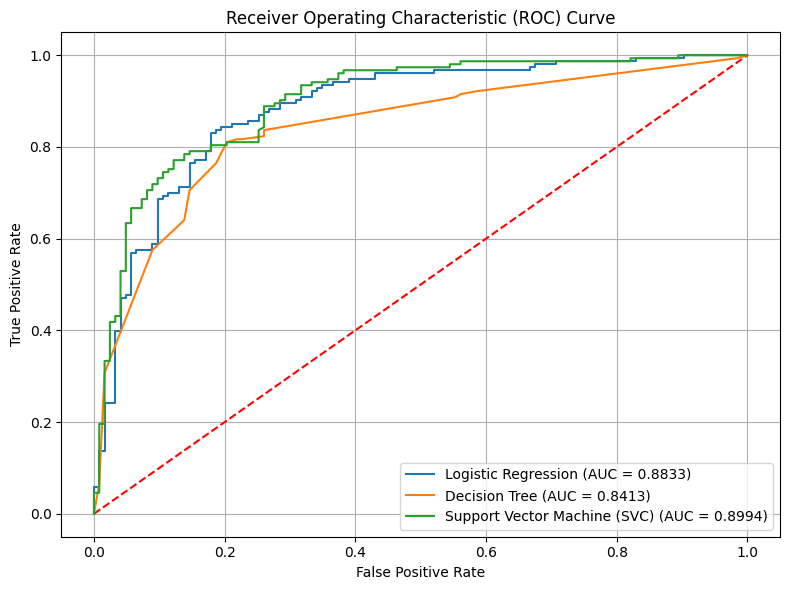

In [ ]:
# --- 7. FINAL RESULTS AND ANALYSIS ---

print("\n--- 7. Final Model Performance Report ---")
best_auc = -np.inf
best_model_name = ""

for name, res in results.items():
    print(f"Model: {name} - Test AUC: {res['test_auc']:.4f}")
    if res['test_auc'] > best_auc:
        best_auc = res['test_auc']
        best_model_name = name

print(f"\nConclusion: The best performing model is the {best_model_name} with an AUC of {best_auc:.4f}.")

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot([0, 1], [0, 1], 'r--')

for name, res in results.items():
    best_model = res['best_estimator']
    y_test_proba = best_model.predict_proba(X_test_raw)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {res["test_auc"]:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('model_roc_curves.png')
print("")

# Why the Best Model Performed Better
if best_model_name == 'Logistic Regression':
    print("\nReason for superior performance:")
    print("The Logistic Regression model performed best, suggesting scaling plus the engineered features helped linearize the relationship while regularization prevented overfitting.")
elif best_model_name == 'Support Vector Machine (SVC)':
    print("\nReason for superior performance:")
    print("The SVC with an RBF kernel performed best, indicating non-linear structure in the transformed feature space; maximizing the margin in a higher-dimensional map generalized well.")
elif best_model_name == 'Decision Tree':
    print("\nReason for superior performance:")
    print("A tuned Decision Tree performed best, implying predictive signal concentrated in a few strong thresholds/rules. Proper depth and leaf-size pruning balanced fit vs. generalization.")
